[View in Colaboratory](https://colab.research.google.com/github/calicinio/Testando/blob/master/Copy_of_Copy_of_tsne.ipynb)

# t-Distributed Stochastic Neighbor Embedding (t-SNE)

**Autores**: 

- Matheus de Oliveira Mendonça, 2018686938

- Thiago Melo Machado Coelho, 2017764242

- Grazielle Félix da Silva, 2017764510

- Wilson Salomão Félix Júnior, 2012021950

- Rudison Carvalho Lacerda, 2017718453

Enviar para: [tsneiic12018@gmail.com](mailto:tsneiic12018@gmail.com)




## Teoria

O t-SNE (*t-distributed Stochastic Neighbor Embedding*) é um algoritomo desenvolvido por van
der Maaten e Hinton para visualizar dados de alta dimensão. O seu objetivo é, a partir de um conjunto de pontos em um espaço de muitas dimensões, encontrar uma representação desses dados em um espaço de dimensão de 2 ou 3 dimensões, para facilitar a visualização e as análises que podem ser feitas neles.

A seguir, é apresentada uma breve explicação da formulação matemática do método SNE (*Stochastic Neighbor Embedding*) que é a base do t-SNE, assim como a adaptação feita para se chegar no método propriamente dito.

### SNE: Stochastic Neighbor Embedding

O SNE objetiva manter as caratecrísticas estruturais dos dados de alta dimensão quando visualizados em uma dimensão menor. Para isso, medir a similaridade entre pares de pontos no espaço de origem é necessário para converter esses pontos para o espaço de destino.

A similaridade entre os pontos $x_j$ e $x_i$ ($x_j$ e $x_i$ são pontos no espaço de origem) é a probabilidade condicional $p_{j|i}$, que representa a probabilidade de $x_j$ ser vizinho de $x_i$, dada uma distribuição de probabilidade Gaussiana centrada em $x_i$. Para pontos próximos, o valor de $p_{j|i}$ é alto. Matematicamente, a probabilidade condicional $p_{j|i}$ é dada por:

$$p_{j|i}=\frac{\exp(−d(x_i,x_j)/(2\sigma^2_i))}{\sum_{i\neq k}\exp(−d(x_i,x_k)/(2\sigma^2_i))}, p_{i|i}=0,$$

sendo que $\sigma_i$ é a variância da Gaussiana centrada em $x_i$ e $d(\cdot)$ é uma medida de distância (e.g. distância Euclidiana).  Uma distribuição conjunta de probabilidade é então gerada para os pontos:

$$p_{ij}=\frac{p_{j|i}+p_{i|j}}{2N}.$$

A probabilidade  $p_{j|i}$ é igual a zero porque estamos interessados somente na similaridade entre dois pontos distintos.

Já a similaridade entre os pontos $y_i$ e $y_j$ ($y_i$ e $y_j$ são pontos no espaço de destino), é dada por:

$$q_{j|i}=\frac{\exp(−d(x_i,x_j))}{\sum_{i\neq k}\exp(−d(x_i,x_k))}, q_{i|i}=0.$$

Nesse espaço, também é considerada uma distribuição Gaussiana, com variância $1/\sqrt{2}$.

Se os pontos mapeados $y_i$ e $y_j$ modelam corretamente a similaridade dos pontos de alta dimensão $x_i$ e $x_j$,  $p_{ij}$ e $q_{ij}$ serão iguais. Desse modo, o método SNE busca minimizar a relação entre as probabilidades conjuntas $p_{ij}$ e $q_{ij}$ através da seguinte função de custo:

$$C =\sum_i\sum_{j}{p_{ij}\log\frac{p_{ij}}{q_{ij}}}.$$

Então, basta minimizar essa função de custo, utilizando o método do gradiente descente para encontrar os pontos no espaço de dimensão menor, que melhor representam os pontos no espaço de dimensão alta.

### t-SNE

No método t-SNE, a distribuição t-Student com um grau de liberdade (que equivale a uma distribuição de Cauchy) é usada no mapeamento dos pontos em baixa dimensão. Desse modo, a distribuição conjunta $q_{ij}$ é definida como

$$q_{ij}=\frac{(1+||y_i−y_j)||^2)^{−1}}{\sum_{k\neq l}(1+||y_k−y_l)||^2)^{−1}}.$$

Essa mudança, segundo os autores, faz com que o espaço de baixa dimensão seja invariante à escala dos pontos em alta dimensão, tornando o processo de otimização mais robusto.

Artigo original: http://jmlr.csail.mit.edu/papers/volume9/vandermaaten08a/vandermaaten08a.pdf



## Exemplo: visualização de dígitos

Para ilustrar a aplicação do t-SNE, será feito um breve exemplo aplicando o método na base de dados *digits*. Primeiro, vamos importar algumas das bibliotecas que iremos utilizar.

In [0]:
#numpy
import numpy as np
from numpy import linalg
from numpy.linalg import norm
from scipy.spatial.distance import squareform, pdist

#sklearn.
import sklearn
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from sklearn.datasets import load_iris
from sklearn.datasets import fetch_20newsgroups
from sklearn.preprocessing import scale
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA


from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold.t_sne import (_joint_probabilities,
                                    _kl_divergence)

# Random state.
RS = 20150101

#matplotlib para gráficos.
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline

#seaborn para plots
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

# We choose a color palette with seaborn.
palette = np.array(sns.color_palette("hls", 10))

#matplotlib e moviepy para animações.
#from moviepy.video.io.bindings import mplfig_to_npimage
#import moviepy.editor as mpy

Agora  iremos utilizar a base de dados de dígitos da biblioteca *scikit-learn*. Essa base possui $1797$ imagens de dígitos com anotações do número correspondente. Cada imagem tem resolução de $8\times8$ pontos. Vamos carregar  o conjunto de dados.

In [0]:
digits = load_digits()
digits.data.shape

(1797, 64)

Abaixo, temos a visualização inicial dos dados.

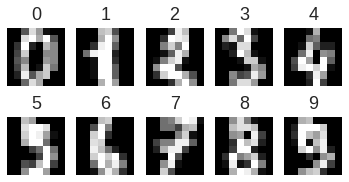

In [0]:
nrows, ncols = 2, 5
plt.figure(figsize=(6,3))
plt.gray()
for i in range(ncols * nrows):
    ax = plt.subplot(nrows, ncols, i + 1)
    ax.matshow(digits.images[i,...])
    plt.xticks([]); plt.yticks([])
    plt.title(digits.target[i])

### t-SNE aplicado no conjunto de dados

Agora iremos aplicar o t-SNE para a projeção do conjuto de dados. Como o conjunto de dados de dígitos tem uma alta dimensão (uma matriz de dimensões $8\times8$), o tSNE é geralmente uma boa solução para conseguir uma representação em 2 dimensões. Para isso, inicialmente vamos reordenar o conjunto de dados de acordo com a ordem dos números:

In [0]:
X = np.vstack([digits.data[digits.target==i]
               for i in range(10)])
y = np.hstack([digits.target[digits.target==i]
               for i in range(10)])

Agora vamos executar o algoritmo t-SNE na base de dados. A biblioteca *scikit-learn* possui uma implementação do algoritmo t-SNE. Dessa forma, é bastante simples utilizá-lo: o método *fit_transform* ajusta o *X* no novo espaço e retorna a saída transformada. Maiores informações sobre a implementação do t-SNE da biblioteca *scikit-learn* podem ser obtidas na documentação da ferramenta em http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html.

In [0]:
digits_proj = TSNE(random_state=RS).fit_transform(X)

O código a seguir é usado para visualizar os dados:

In [0]:
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
        
    plt.show()

    return None

Enfim, é possível visualizar os dados em 2 dimensões.

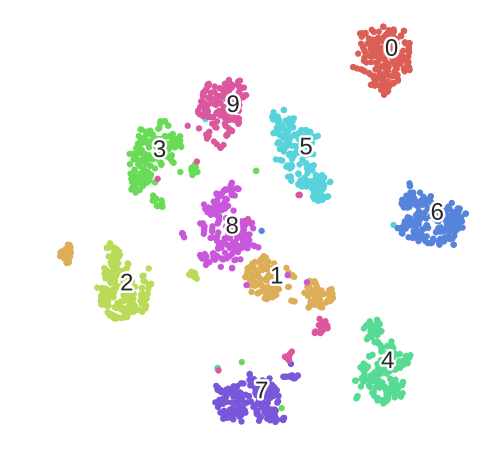

In [0]:
scatter(digits_proj, y)

O algoritmo t-SNE é um bom método para a visualização de conjuntos de dados complexos. Ele consegue encontrar estruturas escondidas nos dados, mostrando clusters e variações não-lineares nas dimensões, e pode ser utilizado facilmente graças à biblioteca scikit-learn.

#Exercício: Iris dataset

Neste exemplo, você deve utilizar o t-SNE para visualizar os dados do conjunto de dados Iris.



Populating the interactive namespace from numpy and matplotlib


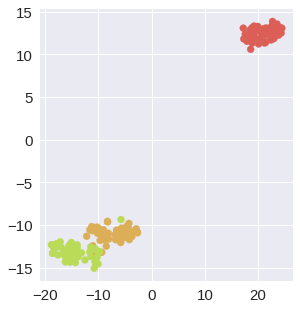

In [0]:
%pylab inline

iris = load_iris()

X, y = iris.data, iris.target

X_tsne = TSNE(random_state=RS).fit_transform(X)

figure(figsize=(10, 5))
subplot(121)
# We choose a color palette with seaborn.
palette = np.array(sns.color_palette("hls", 10))
scatter(X_tsne[:, 0], X_tsne[:, 1], c=palette[iris.target.astype(int)])


#Exercício: 20 newsgroups dataset

O mesmo teste pode ser feito com o conjunto de dados 20 newsgroups, da biblioteca *scikit-learn*. Para dados esparsos de alta dimensão, é útil primeiramente reduzir o número de dimensões para 50 com a utilização do *TruncatedSVD* da *sklearn.decomposition* e, em seguida, executar o t-SNE. Isso geralmente melhora a visualização. 

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups = fetch_20newsgroups(subset="train", categories=categories)
vectors = TfidfVectorizer().fit_transform(newsgroups.data)

X_reduced = TruncatedSVD(n_components=50, random_state=RS).fit_transform(vectors)

Agora você pode usar o t-SNE para conseguir uma clusterização satisfatória dos dados. Com a atribuição de *verbose=2*, é possível verificar a partir de quantas iterações o algoritmo converge e a redução no erro.

In [0]:
X_embedded = TSNE(verbose=2, random_state=RS).fit_transform(X_reduced)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2034 samples in 0.003s...
[t-SNE] Computed neighbors for 2034 samples in 0.525s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2034
[t-SNE] Computed conditional probabilities for sample 2000 / 2034
[t-SNE] Computed conditional probabilities for sample 2034 / 2034
[t-SNE] Mean sigma: 0.103223
[t-SNE] Computed conditional probabilities in 0.128s
[t-SNE] Iteration 50: error = 77.2934570, gradient norm = 0.1177347 (50 iterations in 3.981s)
[t-SNE] Iteration 100: error = 76.1290741, gradient norm = 0.1155672 (50 iterations in 3.364s)
[t-SNE] Iteration 150: error = 76.4493103, gradient norm = 0.0900681 (50 iterations in 3.373s)
[t-SNE] Iteration 200: error = 76.2549286, gradient norm = 0.1076083 (50 iterations in 3.324s)
[t-SNE] Iteration 250: error = 76.2768097, gradient norm = 0.0766815 (50 iterations in 3.334s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.276810
[t-SNE] Iteration 300: erro

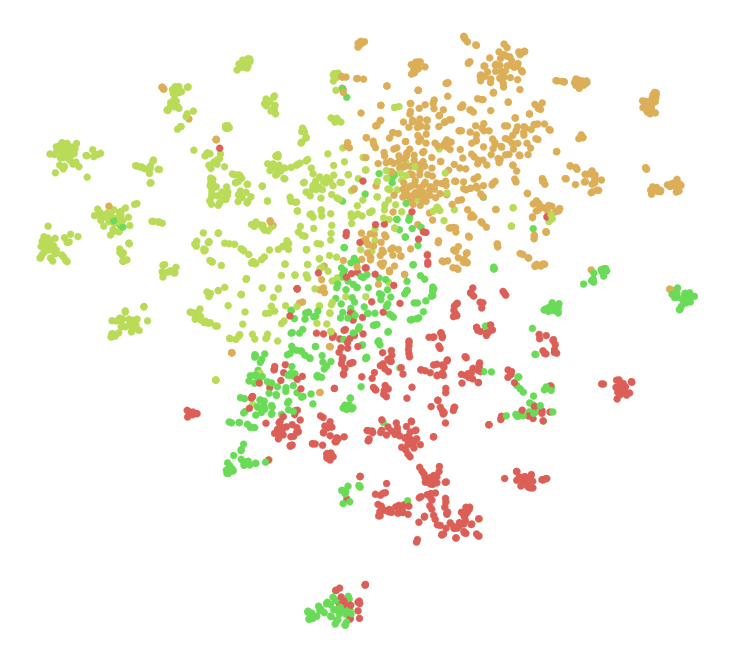

In [0]:
fig = figure(figsize=(10, 10))
ax = axes(frameon=False)
setp(ax, xticks=(), yticks=())
subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.9,
                wspace=0.0, hspace=0.0)
scatter(X_embedded[:, 0], X_embedded[:, 1],
         c=palette[newsgroups.target.astype(int)])